In [11]:
# CVAE-GAN 
# finished at 2020-11-18

In [12]:
!/opt/bin/nvidia-smi

!rm -rf /content/sample_data

!rm -rf /content/img_CVAE-GAN

Sun Nov 29 14:06:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    35W /  70W |   1983MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [9]:
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision.utils import make_grid
import os, time
import imageio
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [4]:
class VAE(nn.Module):
    def __init__(self):

        super(VAE, self).__init__()
        
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2,inplace=True),
            
            nn.Conv2d(16,32,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2,inplace=True),
            
            nn.Conv2d(32,32,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2,inplace=True),
            
        )

        self.encoder_fc1=nn.Linear(32*8*8,nz)
        self.encoder_fc2=nn.Linear(32*8*8,nz)

        self.decoder_fc = nn.Linear(nz+10,32 * 4 * 4)
        
        self.decoder_deconv = nn.Sequential(
            # in_channels, out_channels, kernel_size, stride, padding
            nn.ConvTranspose2d(32, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # nn.ConvTranspose2d(128, 64, 4, 2, 1),
            # nn.BatchNorm2d(64),
            # nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 16, 4, 2, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 3, 4, 2, 1),
            nn.Tanh(),
        )

    def noise_reparameterize(self,mean,logvar):
        eps = torch.randn(mean.shape).to(device)
        z = mean + eps * torch.exp(logvar)
        return z

    def encoder(self,x):
        out1, out2 = self.encoder_conv(x), self.encoder_conv(x)
        mean = self.encoder_fc1(out1.view(out1.shape[0], -1))
        logstd = self.encoder_fc2(out2.view(out2.shape[0], -1))
        z = self.noise_reparameterize(mean, logstd)
        return z,mean,logstd

    def decoder(self,z):
        out3 = self.decoder_fc(z)
        out3 = out3.view(out3.shape[0], 32, 4, 4)
        out3 = self.decoder_deconv(out3)
        return out3

    def forward(self, x):
        z = self.encoder(x)
        output = self.decoder(z)
        return output

In [5]:
class Classifier(nn.Module):
    def __init__(self,outputn=10):
        super(Classifier, self).__init__()
        self.dis = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.MaxPool2d((2, 2)),
        )
        self.fc = nn.Sequential(
            nn.Linear(16384, 2048),
            nn.LeakyReLU(0.2, True),
            nn.Linear(2048, 1024),
            nn.LeakyReLU(0.2, True),
            nn.Linear(1024, outputn),
            nn.Sigmoid()
        )

    def forward(self, input):
        x = self.dis(input)

        x = x.view(x.size(0), -1)

        x = self.fc(x)
        return x.squeeze(1)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.dis = nn.Sequential(
            nn.Linear(3072, 1024),  # 输入特征数为784，输出为256
            nn.LeakyReLU(0.2),  # 进行非线性映射
            nn.Linear(1024, 256),  # 进行一个线性映射
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()  # 也是一个激活函数，二分类问题中，
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.dis(x)
        return x

In [7]:
# def loss_function(recon_x,x,mean,logstd):
#     # BCE = F.binary_cross_entropy(recon_x,x,reduction='sum')
#     MSE = MSECriterion(recon_x,x)
#     # 因为var是标准差的自然对数，先求自然对数然后平方转换成方差
#     var = torch.pow(torch.exp(logstd),2)
#     KLD = -0.5 * torch.sum(1+torch.log(var)-torch.pow(mean,2)-var)
#     return MSE+KLD

def loss_function(recon_x,x,mean,logstd):
    # BCE = F.binary_cross_entropy(recon_x,x,reduction='sum')
    MSE = MSECriterion(recon_x,x)
    return MSE+js_div(recon_x,x)

def js_div(p_output, q_output, get_softmax=True):
    """
    Function that measures JS divergence between target and output logits:
    """
    KLDivLoss = nn.KLDivLoss(reduction='batchmean')
    if get_softmax:
        p_output = F.softmax(p_output)
        q_output = F.softmax(q_output)
    log_mean_output = ((p_output + q_output )/2).log()
    return (KLDivLoss(log_mean_output, p_output) + KLDivLoss(log_mean_output, q_output))/2

In [10]:
if __name__ == '__main__':
    batchSize = 128
    nz = 100
    nepoch = 200
     
    if not os.path.exists('./img_CVAE-GAN'):
        os.mkdir('./img_CVAE-GAN')

    random.seed(1)
    torch.manual_seed(1)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
 
    cudnn.benchmark = True

    dataset = datasets.CIFAR10(root='./data',
                         train=True,
                         transform=transforms.Compose([transforms.ToTensor()]),
                         download=True
                         )

    dataloader = torch.utils.data.DataLoader(dataset,
                        batch_size=batchSize,
                        shuffle=True)
    
    print("=====> Initialization")
    # encoder + decoder = VAE
    vae = VAE().to(device)
    # vae.load_state_dict(torch.load('./CVAE-GAN-VAE.pth'))

    # discriminator
    D = Discriminator().to(device)
    # D.load_state_dict(torch.load('./CVAE-GAN-Discriminator.pth'))

    # Classifier
    C = Classifier(10).to(device)
    # C.load_state_dict(torch.load('./CVAE-GAN-Classifier.pth'))
    
    criterion = nn.BCELoss().to(device)
    MSECriterion = nn.MSELoss().to(device)

    loss_d = []
    loss_c = []
    loss_g = []

    optimizerD = optim.Adam(D.parameters(), lr=0.0001,betas=(0.5, 0.999))
    optimizerC = optim.Adam(C.parameters(), lr=0.0001,betas=(0.5, 0.999))
    optimizerVAE = optim.Adam(vae.parameters(), lr=0.0001,betas=(0.5, 0.999))
    
    # sample_label
    s_label = []
    for i in [0,1,2,3,4,5,6,7,8,9]:
      s_label += [ i for _ in range(8)]
    specific_label = torch.zeros((80, 10)).cuda()
    specific_label[torch.arange(80), s_label] = 1

    print("=====> Start Training")
    start_time = time.time()
    for epoch in range(nepoch):

        epoch_start_time = time.time()

        for i, (data,label) in enumerate(dataloader, 0):
            
            # data processing
            data = data.to(device)
            label_onehot = torch.zeros((data.shape[0], 10)).to(device)
            label_onehot[torch.arange(data.shape[0]), label] = 1
            batch_size = data.shape[0]

            # training C with real
            output = C(data)
            real_label = label_onehot.to(device)
            errC = criterion(output, real_label)
            C.zero_grad()
            errC.backward()
            optimizerC.step()

            # training D with real and fake
            output = D(data)
            real_label = torch.ones(batch_size).to(device)   
            fake_label = torch.zeros(batch_size).to(device)  
            errD_real = criterion(output.view(-1), real_label)

            z = torch.randn(batch_size,nz + 10).to(device)
            fake_data = vae.decoder(z)
            output = D(fake_data)
            errD_fake = criterion(output.view(-1), fake_label)

            errD = errD_real+errD_fake
            D.zero_grad()
            errD.backward()
            optimizerD.step()

            # update VAE(G)1
            z,mean,logstd = vae.encoder(data)
            z = torch.cat([z,label_onehot],1)
            recon_data = vae.decoder(z)
            vae_loss1 = loss_function(recon_data,data,mean,logstd)

            # update VAE(G)2
            output = D(recon_data)
            real_label = torch.ones(batch_size).to(device)
            vae_loss2 = criterion(output.view(-1),real_label)

            # update VAE(G)3
            output = C(recon_data)
            real_label = label_onehot
            vae_loss3 = criterion(output, real_label)

            vae.zero_grad()
            vae_loss = vae_loss1+vae_loss2+vae_loss3
            vae_loss.backward()
            optimizerVAE.step()

        # print per-epoch
        epoch_end_time = time.time()
        per_epoch_ptime = epoch_end_time - epoch_start_time
        print('[%d/%d] time: %.2f Loss_D: %.4f Loss_C: %.4f Loss_G: %.4f'
                  % (epoch+1, nepoch, per_epoch_ptime, errD.item(),errC.item(),vae_loss.item()))
        
        loss_d.append(errD.item())
        loss_c.append(errC.item())
        loss_g.append(vae_loss.item())

        sample = torch.randn(data.shape[0], nz).to(device)
        # data.shape[0] == 80
        # sample.shape: 80*100
        # real_label.shape: 80*10
        # sample.shape after cat: 80*110
        sample = torch.cat([sample,specific_label],1)
        # output.shape: torch.Size([80, 3, 32, 32])
        output = vae.decoder(sample)
        fake_images = make_grid(output.cpu(), nrow=8, normalize=True).detach()
        save_image(fake_images, './img_CVAE-GAN/fake_images-{}.png'.format(epoch+1))

    end_time = time.time()
    total_time = end_time - start_time
    print("total time: %.2f " % total_time )

images = []
for e in range(nepoch):
    img_name = './img_CVAE-GAN/fake_images-' + str(e+1) + '.png'
    images.append(imageio.imread(img_name))
imageio.mimsave('./generation_animation.gif', images, fps=2)


# torch.save(vae.state_dict(), './CVAE-GAN-VAE.pth')
# torch.save(D.state_dict(),'./CVAE-GAN-Discriminator.pth')
# torch.save(C.state_dict(),'./CVAE-GAN-Classifier.pth')

Files already downloaded and verified
=====> Initialization
=====> Start Training


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[1/200] time: 22.94 Loss_D: 0.0005 Loss_C: 0.2236 Loss_G: 1.6018
[2/200] time: 23.04 Loss_D: 0.0000 Loss_C: 0.1698 Loss_G: 1.5154
[3/200] time: 23.00 Loss_D: 0.0000 Loss_C: 0.1631 Loss_G: 1.3044
[4/200] time: 22.58 Loss_D: 0.0000 Loss_C: 0.1708 Loss_G: 1.3214
[5/200] time: 22.65 Loss_D: 0.0000 Loss_C: 0.1401 Loss_G: 1.2281
[6/200] time: 22.71 Loss_D: 0.0000 Loss_C: 0.1304 Loss_G: 1.0997
[7/200] time: 22.79 Loss_D: 0.0087 Loss_C: 0.1717 Loss_G: 1.4987
[8/200] time: 22.65 Loss_D: 0.0014 Loss_C: 0.1287 Loss_G: 1.2546
[9/200] time: 22.73 Loss_D: 0.0007 Loss_C: 0.0980 Loss_G: 1.1592
[10/200] time: 22.64 Loss_D: 0.0093 Loss_C: 0.0879 Loss_G: 1.1241
[11/200] time: 22.76 Loss_D: 0.0048 Loss_C: 0.0728 Loss_G: 0.4346
[12/200] time: 22.89 Loss_D: 0.0073 Loss_C: 0.0563 Loss_G: 0.3725
[13/200] time: 22.67 Loss_D: 100.0000 Loss_C: 0.0412 Loss_G: 0.3403
[14/200] time: 22.69 Loss_D: 100.0000 Loss_C: 0.0478 Loss_G: 0.2845
[15/200] time: 22.71 Loss_D: 100.0000 Loss_C: 0.0361 Loss_G: 0.2423
[16/200] time

KeyboardInterrupt: ignored

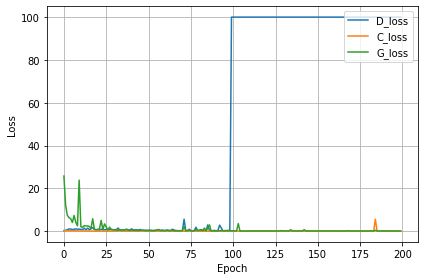

In [ ]:
def show_train_hist(d_loss, c_loss, g_loss):
    x = range(len(d_loss))

    y1 = d_loss
    y2 = c_loss
    y3 = g_loss

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='C_loss')
    plt.plot(x, y3, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=1)
    plt.grid(True)
    plt.tight_layout()

    plt.show()

show_train_hist(loss_d, loss_c, loss_g)

In [ ]:
!cp -r /content/img_CVAE-GAN/ /content/drive/MyDrive
!cp -r /content/generation_animation.gif /content/drive/MyDrive